# Cifar Library and Demo

[This is a library](https://pkg.go.dev/github.com/gomlx/gomlx/examples/cifar) to download and parse the Cifar datasets (Cifar-10 and Cifar-100), and a very small demo of a FNN (Feedforward Neural Network) with GoMLX. FNNs are notoriously bad for images, but it's only a demo. Look for the Resnet50 model for a more serious image classification model (old but still good -- best results as of the time of this writing is with ViT model).

The CIFAR-10 and CIFAR-100 are labeled subsets of the 80 million tiny images dataset. They were collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. See more details in [its homepage here](https://www.cs.toronto.edu/~kriz/cifar.html).

This notebook serves as documentation and example for the [github.com/gomlx/gomlx/examples/cifar](https://github.com/gomlx/gomlx/examples/cifar) library.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

### Downloading data files

To download, uncompress and untar to the local directory, simply do the following. Notice if it's already downloaded in the given `--data` directory, it returns immediately.

In [2]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/data"
)

var flagDataDir = flag.String("data", "~/work/cifar", "Directory to cache downloaded and generated dataset files.")

func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

func AssertDownloaded() {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    AssertNoError(cifar.DownloadCifar10(*flagDataDir))
    AssertNoError(cifar.DownloadCifar100(*flagDataDir))
}

%%
AssertDownloaded()

In [3]:
!ls -lh ~/work/cifar/

total 323M
drwxr-xr-x 2 janpf janpf 4.0K Feb 20  2010 cifar-100-binary
-rw-r--r-- 1 janpf janpf 161M Mar 16 07:57 cifar-100-binary.tar.gz
drwxr-xr-x 2 janpf janpf 4.0K Jun  4  2009 cifar-10-batches-bin
-rw-r--r-- 1 janpf janpf 163M Mar 16 07:57 cifar-10-binary.tar.gz


### Sample some images

The `cifar.LoadCifar10` and `cifar.LoadCifar100` funcitons load the whole dataset into a `tensor.Tensor`. Here we sample and display a few of each, to check things are working.


Example 40447: horse (7),Example 20934: frog (6),Example 39567: truck (9),Example 1219: bird (2)
Example 53997: bird (2),Example 40612: airplane (0),Example 39539: dog (5),Example 13333: horse (7)

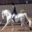
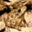
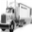
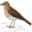
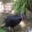
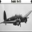
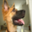
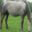

Example 38612: beaver (4),Example 21603: bed (5),Example 21013: skyscraper (76),Example 29138: flatfish (32)
Example 24000: girl (35),Example 45743: table (84),Example 11907: woman (98),Example 37212: whale (95)

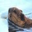
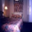
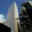
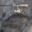
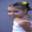
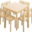
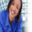
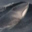

In [5]:
import (
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/types/shapes"

    "github.com/janpfeifer/gonb/gonbui"
)

// sampleToNotebook generates a sample of Cifar-10 and Cifar-100 in a GoNB Jupyter Notebook.
func sampleToNotebook(rows, cols int) {
    dtype := shapes.Float32
    
    // Load data into tensors.
    images10, labels10, err := cifar.LoadCifar10(*flagDataDir, dtype)
    AssertNoError(err)
    images100, labels100, err := cifar.LoadCifar100(*flagDataDir, dtype)
    AssertNoError(err)
    
    sampleTable("Samples from Cifar-10", images10.Local(), labels10.Local(), cifar.C10Labels[:], rows, cols)
    sampleTable("Samples from Cifar-100", images100.Local(), labels100.Local(), cifar.C100FineLabels[:], rows, cols)
}

// sampleTable generates and outputs one html table of samples, sampling rows x cols from the images/labels provided.
func sampleTable(title string, images, labels *tensor.Local, labelsText []string, rows, cols int) {
    htmlRows := make([]string, 0, rows)
    for row := 0; row < rows; row++ {
        cells := make([]string, 0, cols)
        for col := 0; col < cols; col++ {
            cells = append(cells, sampleOneImage(images, labels, labelsText))
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", title, strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// sampleOneImage one image from tensor and returns an HTML rendered image with label
func sampleOneImage(images, labels *tensor.Local, labelsText []string) string {
    exampleNum := rand.Intn(images.Shape().Dimensions[0])
    labelsData := labels.Flat().([]int)
    label := labelsData[exampleNum]
    labelStr := labelsText[label]
    img := cifar.ConvertToGoImage(images, exampleNum)
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center;"><img width="128" height="128" src="%s"><figcaption style="text-align: center;">Example %d: %s (%d)</figcaption></figure>`, imgSrc, exampleNum, labelStr, label)
}

%%
AssertDownloaded()
rows, cols := 2, 4
sampleToNotebook(rows, cols)

## Training on Cifar-10

### Models Support

In this cell we define 3 functions we are going to use for the modeling:

1. `getBatchedImages`: this will take the `cifar.Dataset` yielded `spec`, and convert the image indices that are given as input, and convert them to the actual batch of images. The whole Cifar-10 dataset is configured as a variable -- so it can be stored in the accelerator memory for faster access. This function will call the `Dataset.GatherImagesGraph` to retrieve it.
1. `normalizeImage` and `normalizeFeatures`: they normalize `x` according to the hyperparameter given in `flagNormalization` flag.


In [6]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
)

var (
    // ML Manager creation:
    flagNumThreads  = flag.Int("num_threads", -1, "Number of threads. Leave as -1 to use as many as there are cores.")
    flagNumReplicas = flag.Int("num_replicas", 1, "Number of replicas.")
    flagPlatform    = flag.String("platform", "", "Platform to use, if empty uses the default one.")

    // Model hyper-parameters.
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagNormalization    = flag.String("norm", "layer", "Type of normalization to use. Valid values are \"none\", \"batch\", \"layer\".")

    // Model hyperparameters:
    flagNumHiddenLayers = flag.Int("hidden_layers", 8, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")
    flagDropoutRate     = flag.Float64("dropout", 0, "Dropout rate")
)

func getBatchedImages(ctx *context.Context, spec any, inputs []*Node) (batchedImages *Node) {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }

    if spec != nil {
        // spec should hold the dataset that converts the image indices to the actual
        // images, by gathering from a large variable that holds all the images.
        dataset, ok := spec.(*cifar.Dataset)
        if !ok {
            g.SetErrorf("spec given to FNNModelGraph is not a *cifarDataset, instead got %T", spec)
            return nil
        }
        // We assume that batchedImages passed is actually a list of indices, and we need to gather
        // the actual images.
        batchedImages = dataset.GatherImagesGraph(ctx, inputs[0])
    } else {
        // If a spec was not given, we assume the raw images are being fed for inference.
        batchedImages = inputs[0]
    }
    if !batchedImages.Ok() {
        g.SetErrorf("failed to load batch of images")
        return nil
    }
    return
}

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4)  // [batch_size, width, height, depth]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2)  // [batch_size, embedding_dim]
    switch *flagNormalization {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    g := x.Graph()
    g.SetErrorf("invalid normalization selected %q -- valid values are batch, layer, none", *flagNormalization)
    return g.InvalidNode()
}

### Simple FNN model

A trivial model, that can easily get to ~45% accuracy (a random model would do 10%), but hardly much more than that.

Later we are going to define a CNN model to compare, and we just set a placeholder model here for now.

> **Note**: 
>
> * Cifar datasets yields (`Dataset.Yield()`) only the indices to the images of the batch as a `Tensor`. But it provides a `GatherImagesGraph` method that gathers the images from a static variable that holds the whole dataset (~1Gb in memory, stored as float32). We access it through the `getBatchedImatges()` defined above. 


In [7]:
import (
    "flags"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train/optimizers"
    "github.com/gomlx/gomlx/types/shapes"
)

var DType = shapes.Float32

func FNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := Reshape(batchedImages, batchSize, -1)
    {
        ctx := ctx.In("Dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("Dense_%d", ii))
        // Add layer with residual connection.
        tmp := Sigmoid(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = Sigmoid(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

// Only a placeholder for now.
func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil   
}

%% --platform=Host

// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, 3, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
logits := FNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())


Logits shape for batch_size=3: (Float32)[3 10]


### Training Loop

With a model function defined, let's create our training loop, with the usual bells and whistles: accuracy metrics, progress-bar, plot of metrics, checkpoints.

In [8]:
import (
    "flags"
    
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    // Training flags:
    flagModel            = flag.String("model", "fnn", "Model type: fnn or cnn.")
    flagNumSteps         = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagBatchSize        = flag.Int("batch", 50, "Batch size for training")
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %v", slices.Keys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagCheckpoint       = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep   = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    
    // Training UI:
    flagUseProgressBar = flag.Bool("bar", true, "If to display a progress bar during training")
    flagNumPlotPoints  = flag.Int("plot_points", 50, "Number points to plot.")
)

var (
    // DType used for the model.
    DType = shapes.Float32
    
    // EvalBatchSize can be larger than training, more efficient.
    EvalBatchSize = 2000
)


func trainModel() {
    // Make sure data is downloaded.
    AssertDownloaded()

    // Manager handles creation of ML computation graphs, accelerator resources, etc.
    manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
    fmt.Printf("Platform: %s\n", manager.Platform())

    // Create datasets used for training and evaluation.
    trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
    AssertNoError(err)
    evalOnTestDS, err := cifar.NewDataset("Cifar-10 Eval On Test", *flagDataDir, cifar.C10, DType, cifar.Test, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)
    evalOnTrainDS, err := cifar.NewDataset("Cifar-10 Eval On Train", *flagDataDir, cifar.C10, DType, cifar.Train, EvalBatchSize, true) // 1 epoch.
    AssertNoError(err)

    // Create closure for model graph building function, that uses statically the dataset
    // used for its `cifar.Dataset.GatherImageGraph`, to convert image indices to the actual images.
    // This is the signature of model function that the train.Trainer accepts.
    modelFn := FNNModelGraph
    if *flagModel == "cnn" {
        modelFn = CNNModelGraph
    }

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewSparseCategoricalAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageSparseCategoricalAccuracy("Moving Average Accuracy", "~acc", 0.01)

    // Context holds the variables and hyperparameters for the model.
    ctx := context.NewContext(manager)
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)

    // Checkpoints saving.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        checkpointPath := data.ReplaceTildeInDir(*flagCheckpoint)
        if !path.IsAbs(checkpointPath) {
            checkpointPath = path.Join(*flagDataDir, checkpointPath)
        }
        var err error
        checkpoint, err = checkpoints.Build(ctx).Dir(checkpointPath).Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    }

    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        losses.SparseCategoricalCrossEntropyLogits,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    if *flagUseProgressBar {
        commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.
    }

    // Attach a checkpoint.
    if checkpoint != nil {
        train.NTimesDuringLoop(loop, *flagCheckpointKeep, "checkpointing", 100, func(_ *train.Loop, _ []tensor.Tensor) error {
            return checkpoint.Save()
        })
    }

    // Attach a margaid plots.
    if *flagNumPlotPoints > 0 {
        margaid.New(1024, 400, evalOnTrainDS, evalOnTestDS).DynamicUpdates().Attach(loop, *flagNumPlotPoints)
    }

    // Loop for given number of steps.
    _, err = loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)

    // Finally print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, evalOnTrainDS, evalOnTestDS)
    AssertNoError(err)
    fmt.Println()

    // Release memory -- not really needed since we are exiting, just for the example.
    cifar.ResetCache()
}

%% --model=fnn --steps=500 --plot_points=0
trainModel()

Platform: CUDA
Training (500 steps):  100% [========================================] (118 steps/s) [loss=1.810] [~loss=1.931] [~acc=32.47%]        

Results on Cifar-10 Eval On Train:
	Mean Loss (#loss): 1.881
	Mean Accuracy (#acc): 34.15%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.882
	Mean Accuracy (#acc): 34.06%



### FNN Model Training

Let's train the FNN for real this time.

In [9]:
%% --model=fnn --steps=10000 --norm=layer
trainModel()

Platform: CUDA


Training (10000 steps):  100% [========================================] (533 steps/s) [loss=1.371] [~loss=1.411] [~acc=49.68%]        


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.274191e+00 L3.456962e+01,1.241585e+02 L5.154412e+01,1.349774e+02 L6.851862e+01,1.557497e+02 L8.549312e+01,1.644666e+02 L1.024676e+02,1.682996e+02 L1.194421e+02,1.836315e+02 L1.364166e+02,1.809113e+02 L1.533911e+02,1.800458e+02 L1.703656e+02,1.875263e+02 L1.873401e+02,1.969851e+02 L2.043146e+02,1.989016e+02 L2.212891e+02,1.980979e+02 L2.382636e+02,1.958105e+02 L2.552381e+02,2.034765e+02 L2.722126e+02,2.053930e+02 L2.891871e+02,2.083604e+02 L3.061616e+02,2.097823e+02 L3.231361e+02,2.129353e+02 L3.401106e+02,2.055166e+02 L3.570851e+02,2.175101e+02 L3.740596e+02,2.107097e+02 L3.910341e+02,2.146045e+02 L4.080086e+02,2.170774e+02 L4.249831e+02,2.160264e+02 L4.419576e+02,2.131207e+02 L4.589321e+02,2.233214e+02 L4.759066e+02,2.327184e+02 L4.928811e+02,2.231978e+02 L5.098556e+02,2.195503e+02 L5.268301e+02,2.218377e+02 L5.438045e+02,2.265362e+02 L5.607790e+02,2.257325e+02 L5.777535e+02,2.304310e+02 L5.947280e+02,2.280817e+02 L6.117025e+02,2.246815e+02 L6.286770e+02,2.254852e+02 L6.456515e+02,2.382824e+02 L6.626260e+02,2.346349e+02 L6.796005e+02,2.278963e+02 L6.965750e+02,2.366132e+02 L7.135495e+02,2.350058e+02 L7.305240e+02,2.347586e+02 L7.474985e+02,2.310492e+02 L7.644730e+02,2.350677e+02 L7.814475e+02,2.293182e+02 L7.984220e+02,2.278344e+02 L8.153965e+02,2.321620e+02 L8.323710e+02,2.393952e+02 L8.493455e+02,2.351913e+02 L8.663200e+02,2.379733e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L3.456962e+01,1.233548e+02 L5.154412e+01,1.378335e+02 L6.851862e+01,1.553169e+02 L8.549312e+01,1.674588e+02 L1.024676e+02,1.702284e+02 L1.194421e+02,1.806269e+02 L1.364166e+02,1.811215e+02 L1.533911e+02,1.824816e+02 L1.703656e+02,1.866361e+02 L1.873401e+02,1.972819e+02 L2.043146e+02,2.004348e+02 L2.212891e+02,1.977270e+02 L2.382636e+02,1.968367e+02 L2.552381e+02,2.072229e+02 L2.722126e+02,2.073836e+02 L2.891871e+02,2.115010e+02 L3.061616e+02,2.122305e+02 L3.231361e+02,2.167435e+02 L3.401106e+02,2.083357e+02 L3.570851e+02,2.221839e+02 L3.740596e+02,2.151238e+02 L3.910341e+02,2.177574e+02 L4.080086e+02,2.210216e+02 L4.249831e+02,2.188455e+02 L4.419576e+02,2.181654e+02 L4.589321e+02,2.306659e+02 L4.759066e+02,2.366626e+02 L4.928811e+02,2.276366e+02 L5.098556e+02,2.228268e+02 L5.268301e+02,2.331388e+02 L5.438045e+02,2.315561e+02 L5.607790e+02,2.362546e+02 L5.777535e+02,2.392839e+02 L5.947280e+02,2.411757e+02 L6.117025e+02,2.361433e+02 L6.286770e+02,2.378620e+02 L6.456515e+02,2.513022e+02 L6.626260e+02,2.461462e+02 L6.796005e+02,2.389995e+02 L6.965750e+02,2.505108e+02 L7.135495e+02,2.490642e+02 L7.305240e+02,2.480998e+02 L7.474985e+02,2.484707e+02 L7.644730e+02,2.504737e+02 L7.814475e+02,2.386657e+02 L7.984220e+02,2.440071e+02 L8.153965e+02,2.460225e+02 L8.323710e+02,2.540347e+02 L8.493455e+02,2.514753e+02 L8.663200e+02,2.493362e+02 "/> <path d="M1.768000e+01,5.336005e+00 L3.456962e+01,8.522585e+01 L5.154412e+01,1.267172e+02 L6.851862e+01,1.542273e+02 L8.549312e+01,1.598081e+02 L1.024676e+02,1.682292e+02 L1.194421e+02,1.766459e+02 L1.364166e+02,1.837184e+02 L1.533911e+02,1.876559e+02 L1.703656e+02,1.888286e+02 L1.873401e+02,1.884436e+02 L2.043146e+02,1.975473e+02 L2.212891e+02,1.955950e+02 L2.382636e+02,2.009673e+02 L2.552381e+02,1.981516e+02 L2.722126e+02,2.031375e+02 L2.891871e+02,2.070744e+02 L3.061616e+02,2.097607e+02 L3.231361e+02,2.156443e+02 L3.401106e+02,2.125886e+02 L3.570851e+02,2.178322e+02 L3.740596e+02,2.218565e+02 L3.910341e+02,2.195489e+02 L4.080086e+02,2.235457e+02 L4.249831e+02,2.236010e+02 L4.419576e+02,2.263298e+02 L4.589321e+02,2.296961e+02 L4.759066e+02,2.274394e+02 L4.928811e+02,2.301046e+02 L5.098556e+02,2.283600e+02 L5.268301e+02,2.330136e+02 L5.438045e+02,2.324566e+02 L5.607790e+02,2.338624e+02 L5.777535e+02,2.360190e+02 L5.947280e+02,2.416765e+02 L6.117025e+02,2.370032e+02 L6.286770e+02,2.442827e+02 L6.456515e+02,2.397359e+02 L6.626260e+02,2.399701e+02 L6.796005e+02,2.439039e+02 L6.965750e+02,2.431271e+02 L7.135495e+02,2.402628e+02 L7.3052


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.358784e+02 L3.456962e+01,1.568764e+02 L5.154412e+01,1.348087e+02 L6.851862e+01,1.164744e+02 L8.549312e+01,1.071330e+02 L1.024676e+02,1.029505e+02 L1.194421e+02,8.906548e+01 L1.364166e+02,8.804960e+01 L1.533911e+02,8.739564e+01 L1.703656e+02,8.152268e+01 L1.873401e+02,7.281342e+01 L2.043146e+02,7.052212e+01 L2.212891e+02,6.798164e+01 L2.382636e+02,7.382694e+01 L2.552381e+02,6.291751e+01 L2.722126e+02,6.259966e+01 L2.891871e+02,5.677955e+01 L3.061616e+02,5.707083e+01 L3.231361e+02,5.216675e+01 L3.401106e+02,6.337325e+01 L3.570851e+02,4.797765e+01 L3.740596e+02,5.529178e+01 L3.910341e+02,5.189343e+01 L4.080086e+02,4.741912e+01 L4.249831e+02,5.065753e+01 L4.419576e+02,4.824274e+01 L4.589321e+02,4.052429e+01 L4.759066e+02,3.496757e+01 L4.928811e+02,4.180103e+01 L5.098556e+02,4.902989e+01 L5.268301e+02,4.120332e+01 L5.438045e+02,3.831586e+01 L5.607790e+02,3.554199e+01 L5.777535e+02,3.270160e+01 L5.947280e+02,3.050955e+01 L6.117025e+02,3.630309e+01 L6.286770e+02,3.699597e+01 L6.456515e+02,2.484178e+01 L6.626260e+02,2.943426e+01 L6.796005e+02,3.348040e+01 L6.965750e+02,2.508157e+01 L7.135495e+02,2.651401e+01 L7.305240e+02,2.531329e+01 L7.474985e+02,2.822424e+01 L7.644730e+02,2.423561e+01 L7.814475e+02,3.829381e+01 L7.984220e+02,2.917898e+01 L8.153965e+02,3.132529e+01 L8.323710e+02,2.239941e+01 L8.493455e+02,2.708815e+01 L8.663200e+02,2.410806e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.359781e+02 L3.456962e+01,1.567215e+02 L5.154412e+01,1.344930e+02 L6.851862e+01,1.156098e+02 L8.549312e+01,1.068621e+02 L1.024676e+02,1.025362e+02 L1.194421e+02,8.891767e+01 L1.364166e+02,8.777150e+01 L1.533911e+02,8.611688e+01 L1.703656e+02,8.074313e+01 L1.873401e+02,7.205707e+01 L2.043146e+02,6.920565e+01 L2.212891e+02,6.712437e+01 L2.382636e+02,7.190565e+01 L2.552381e+02,6.014574e+01 L2.722126e+02,5.973949e+01 L2.891871e+02,5.471324e+01 L3.061616e+02,5.411227e+01 L3.231361e+02,4.828986e+01 L3.401106e+02,5.885444e+01 L3.570851e+02,4.340769e+01 L3.740596e+02,5.011875e+01 L3.910341e+02,4.666527e+01 L4.080086e+02,4.170065e+01 L4.249831e+02,4.616754e+01 L4.419576e+02,4.223941e+01 L4.589321e+02,3.284875e+01 L4.759066e+02,2.789959e+01 L4.928811e+02,3.534107e+01 L5.098556e+02,4.133723e+01 L5.268301e+02,3.271850e+01 L5.438045e+02,3.015839e+01 L5.607790e+02,2.590496e+01 L5.777535e+02,2.348795e+01 L5.947280e+02,2.097042e+01 L6.117025e+02,2.609981e+01 L6.286770e+02,2.583089e+01 L6.456515e+02,1.262645e+01 L6.626260e+02,1.699408e+01 L6.796005e+02,2.159461e+01 L6.965750e+02,1.248969e+01 L7.135495e+02,1.289842e+01 L7.305240e+02,1.119018e+01 L7.474985e+02,1.243563e+01 L7.644730e+02,9.519413e+00 L7.814475e+02,2.519959e+01 L7.984220e+02,1.309888e+01 L8.153965e+02,1.531681e+01 L8.323710e+02,6.685555e+00 L8.493455e+02,1.166140e+01 L8.663200e+02,8.780018e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.456962e+01,1.834670e+02 L5.154412e+01,1.470351e+02 L6.851862e+01,1.223991e+02 L8.549312e+01,1.121248e+02 L1.024676e+02,1.030600e+02 L1.194421e+02,9.620876e+01 L1.364166e+02,8.679626e+01 L1.533911e+02,8.149876e+01 L1.703656e+02,7.826970e+01 L1.873401e+02,7.721150e+01 L2.043146e+02,6.977794e+01 L2.212891e+02,7.012726e+01 L2.382636e+02,6.514168e+01 L2.552381e+02,6.401610e+01 L2.722126e+02,6.459115e+01 L2.891871e+02,5.728261e+01 L3.061616e+02,5.583477e+01 L3.231361e+02,5.304322e+01 L3.401106e+02,5.061274e+01 L3.570851e+02,4.565797e+01 L3.740596e+02,4.472004e+01 L3.910341e+02,4.661875e+01 L4.080086e+02,3.801044e+01 L4.249831e+02,4.098380e+01 L4.419576e+02,3.908050e+01 L4.589321e+02,3.531053e+01 L4.759066e+02,3.728771e+01 L4.928811e+02,3.252917e+01 L5.098556e+02,3.211146e+01 L5.268301e+02,3.237189e+01 L5.438045e+02,2.907898e+01 L5.607790e+02,2.837882e+01 L5.777535e+02,2.464298e+01 L5.947280e+02,2.108908e+01 L6.117025e+02,2.290909e+01 L6.286770e+02,1.687726e+01 L6.456515e+02,2.560720e+01 L6.626260e+02,2.185743e+01 L6.796005e+02,1.863954e+01 L6.965750e+02,1.978055e+01

	Mean Loss (#loss): 1.410
	Mean Accuracy (#acc): 49.47%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.474
	Mean Accuracy (#acc): 47.63%



### CNN model for Cifar-10

Let's now properly define our CNN model to compare:

In [10]:
import (
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/cifar"
    "github.com/gomlx/gomlx/ml/context"
    "github.com/gomlx/gomlx/types/shapes"
)

func CNNModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    g := inputs[0].Graph()
    if !g.Ok() {
        return nil
    }
    batchedImages := getBatchedImages(ctx, spec, inputs)
    if !g.Ok() {
        return nil
    }
    batchSize := batchedImages.Shape().Dimensions[0]
    logits := batchedImages
    {
        ctx := ctx.In("conv_0")
        logits = layers.Convolution(ctx, logits).Filters(32).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_1")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = layers.Relu(logits)
        logits = MaxPool(logits).Window(2).Done()
    }
    {
        ctx := ctx.In("conv_2")
        logits = layers.Convolution(ctx, logits).Filters(64).KernelSize(3).Done()
        logits = normalizeImage(ctx, logits)
        logits = Reshape(logits, batchSize, -1)
        logits = layers.Relu(logits)
    }
    {
        ctx := ctx.In("dense_0")
        logits = layers.DenseWithBias(ctx, logits, *flagNumNodes)
        logits = normalizeFeatures(ctx, logits)
    }
    for ii := 1; ii < *flagNumHiddenLayers; ii++ {
        ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
        // Add layer with residual connection.
        tmp := layers.Relu(logits)
        if *flagDropoutRate > 0 {
            tmp = layers.Dropout(ctx, tmp, Const(g, shapes.CastAsDType(*flagDropoutRate, tmp.DType())))
        }
        tmp = layers.DenseWithBias(ctx, tmp, *flagNumNodes)
        tmp = normalizeFeatures(ctx, tmp)
        logits = Add(logits, tmp)
    }
    logits = layers.Relu(logits)
    logits = layers.DenseWithBias(ctx.In("denseFinal"), logits, len(cifar.C10Labels))
    return []*Node{logits}
}

%% --platform=Host
// Let's test that the logits are coming out with the right shape: we want [batch_size, 10], since there are 10 classes.
AssertDownloaded()
manager := BuildManager().NumThreads(*flagNumThreads).NumReplicas(*flagNumReplicas).Platform(*flagPlatform).MustDone()
trainDS, err := cifar.NewDataset("Cifar-10 Batched Train", *flagDataDir, cifar.C10, DType, cifar.Train, *flagBatchSize, false) // loops forever.
AssertNoError(err)

graph := manager.NewGraph("test")
ctx := context.NewContext(manager)
ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
logits := CNNModelGraph(ctx, trainDS, []*Node{graph.Parameter("images", shapes.Make(shapes.Int64, /*Batch Size*/ 3, 1))})
AssertNoError(graph.Error())
AssertNoError(ctx.Error())
fmt.Printf("Logits shape for batch_size=%d: %s\n", 3, logits[0].Shape())

Logits shape for batch_size=3: (Float32)[3 10]


### Training the CNN model

CNNs have a much better inductive bias for machine learning on images, and it can easily achieve > 80% accuracy in training data, but only > 65% on test data, due to overfitting.

Likely it would benefit from pre-training the model on a larger unlabeled datasets.

In [11]:
%% --model=cnn --steps=20000 --batch=50 --hidden_layers=2 --l2_reg=0.01 --dropout=0.1 --norm=batch
trainModel()

Platform: CUDA


Training (20000 steps):  100% [========================================] (413 steps/s) [loss=1.088] [~loss=1.202] [~acc=85.84%]        


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.385397e+00 L3.461121e+01,1.106296e+02 L5.158486e+01,1.305926e+02 L6.855851e+01,1.468146e+02 L8.553216e+01,1.573423e+02 L1.025058e+02,1.706510e+02 L1.194795e+02,1.723394e+02 L1.364531e+02,1.765108e+02 L1.534268e+02,1.776033e+02 L1.704004e+02,1.817746e+02 L1.873741e+02,1.857473e+02 L2.043477e+02,1.899849e+02 L2.213214e+02,1.733326e+02 L2.382950e+02,1.895215e+02 L2.552686e+02,1.964737e+02 L2.722423e+02,1.903491e+02 L2.892159e+02,1.935273e+02 L3.061896e+02,1.978973e+02 L3.231632e+02,1.905808e+02 L3.401369e+02,1.953150e+02 L3.571105e+02,1.867074e+02 L3.740842e+02,2.004133e+02 L3.910578e+02,1.918720e+02 L4.080315e+02,1.938583e+02 L4.250051e+02,1.978973e+02 L4.419788e+02,1.950502e+02 L4.589524e+02,1.848866e+02 L4.759261e+02,2.073656e+02 L4.928997e+02,1.992877e+02 L5.098734e+02,1.988574e+02 L5.268470e+02,1.968048e+02 L5.438207e+02,1.939908e+02 L5.607943e+02,1.983939e+02 L5.777680e+02,1.999168e+02 L5.947416e+02,1.923686e+02 L6.117153e+02,2.070015e+02 L6.286889e+02,2.029625e+02 L6.456626e+02,2.024659e+02 L6.626362e+02,1.940901e+02 L6.796099e+02,2.036909e+02 L6.965835e+02,2.069021e+02 L7.135572e+02,1.985263e+02 L7.305308e+02,1.957454e+02 L7.475045e+02,1.928983e+02 L7.644781e+02,2.046509e+02 L7.814518e+02,1.882634e+02 L7.984254e+02,2.023666e+02 L8.153991e+02,1.972683e+02 L8.323727e+02,1.989236e+02 L8.493464e+02,1.954805e+02 L8.663200e+02,2.080939e+02 "/> <path d="M1.768000e+01,5.200000e+00 L3.461121e+01,1.132847e+02 L5.158486e+01,1.350685e+02 L6.855851e+01,1.503834e+02 L8.553216e+01,1.632551e+02 L1.025058e+02,1.791592e+02 L1.194795e+02,1.859327e+02 L1.364531e+02,1.895214e+02 L1.534268e+02,1.900048e+02 L1.704004e+02,1.958844e+02 L1.873741e+02,2.036577e+02 L2.043477e+02,2.097029e+02 L2.213214e+02,1.867736e+02 L2.382950e+02,2.098618e+02 L2.552686e+02,2.194692e+02 L2.722423e+02,2.105438e+02 L2.892159e+02,2.190057e+02 L3.061896e+02,2.247728e+02 L3.231632e+02,2.146887e+02 L3.401369e+02,2.230447e+02 L3.571105e+02,2.129672e+02 L3.740842e+02,2.291693e+02 L3.910578e+02,2.199393e+02 L4.080315e+02,2.193169e+02 L4.250051e+02,2.246470e+02 L4.419788e+02,2.230645e+02 L4.589524e+02,2.103783e+02 L4.759261e+02,2.404518e+02 L4.928997e+02,2.324666e+02 L5.098734e+02,2.263685e+02 L5.268470e+02,2.257130e+02 L5.438207e+02,2.261036e+02 L5.607943e+02,2.339564e+02 L5.777680e+02,2.332413e+02 L5.947416e+02,2.234419e+02 L6.117153e+02,2.441796e+02 L6.286889e+02,2.418754e+02 L6.456626e+02,2.403989e+02 L6.626362e+02,2.300896e+02 L6.796099e+02,2.437161e+02 L6.965835e+02,2.500062e+02 L7.135572e+02,2.369095e+02 L7.305308e+02,2.302287e+02 L7.475045e+02,2.318774e+02 L7.644781e+02,2.454906e+02 L7.814518e+02,2.261831e+02 L7.984254e+02,2.431334e+02 L8.153991e+02,2.419284e+02 L8.323727e+02,2.458746e+02 L8.493464e+02,2.370154e+02 L8.663200e+02,2.548000e+02 " vector-effect="non-scaling-stroke"/> <path d="M1.768000e+01,1.684010e+01 L3.461121e+01,9.995141e+01 L5.158486e+01,1.270056e+02 L6.855851e+01,1.508557e+02 L8.553216e+01,1.631986e+02 L1.025058e+02,1.716898e+02 L1.194795e+02,1.818341e+02 L1.364531e+02,1.861272e+02 L1.534268e+02,1.921256e+02 L1.704004e+02,1.971919e+02 L1.873741e+02,2.056993e+02 L2.043477e+02,2.055950e+02 L2.213214e+02,2.109663e+02 L2.382950e+02,2.138820e+02 L2.552686e+02,2.170789e+02 L2.722423e+02,2.181942e+02 L2.892159e+02,2.218634e+02 L3.061896e+02,2.212858e+02 L3.231632e+02,2.232767e+02 L3.401369e+02,2.260383e+02 L3.571105e+02,2.274561e+02 L3.740842e+02,2.295966e+02 L3.910578e+02,2.283188e+02 L4.080315e+02,2.332323e+02 L4.250051e+02,2.324939e+02 L4.419788e+02,2.346936e+02 L4.589524e+02,2.337275e+02 L4.759261e+02,2.348665e+02 L4.928997e+02,2.366257e+02 L5.098734e+02,2.378539e+02 L5.268470e+02,2.376043e+02 L5.438207e+02,2.388867e+02 L5.607943e+02,2.382252e+02 L5.777680e+02,2.415189e+02 L5.947416e+02,2.444428e+02 L6.117153e+02,2.430113e+02 L6.286889e+02,2.442815e+02 L6.456626e+02,2.441656e+02 L6.626362e+02,2.476430e+02 L6.796099e+02,2.480587e+02 L6.965835e+02,2.463530e+02 L7.135572e+02,2.482318e+02 L7.3053


Results on Cifar-10 Eval On Train:


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L3.461121e+01,1.969990e+02 L5.158486e+01,1.620276e+02 L6.855851e+01,1.357384e+02 L8.553216e+01,1.166397e+02 L1.025058e+02,1.011426e+02 L1.194795e+02,8.987759e+01 L1.364531e+02,8.068217e+01 L1.534268e+02,7.276014e+01 L1.704004e+02,6.616872e+01 L1.873741e+02,5.992773e+01 L2.043477e+02,5.449580e+01 L2.213214e+02,5.318743e+01 L2.382950e+02,4.672076e+01 L2.552686e+02,4.223213e+01 L2.722423e+02,4.004548e+01 L2.892159e+02,3.673314e+01 L3.061896e+02,3.369202e+01 L3.231632e+02,3.296739e+01 L3.401369e+02,3.004765e+01 L3.571105e+02,2.953100e+01 L3.740842e+02,2.610257e+01 L3.910578e+02,2.568816e+01 L4.080315e+02,2.461379e+01 L4.250051e+02,2.274042e+01 L4.419788e+02,2.200657e+01 L4.589524e+02,2.328930e+01 L4.759261e+02,1.894249e+01 L4.928997e+02,1.915455e+01 L5.098734e+02,1.910074e+01 L5.268470e+02,1.877906e+01 L5.438207e+02,1.881972e+01 L5.607943e+02,1.733353e+01 L5.777680e+02,1.716345e+01 L5.947416e+02,1.780126e+01 L6.117153e+02,1.521100e+01 L6.286889e+02,1.544735e+01 L6.456626e+02,1.510637e+01 L6.626362e+02,1.636739e+01 L6.796099e+02,1.444286e+01 L6.965835e+02,1.363175e+01 L7.135572e+02,1.486716e+01 L7.305308e+02,1.585211e+01 L7.475045e+02,1.579661e+01 L7.644781e+02,1.360901e+01 L7.814518e+02,1.609285e+01 L7.984254e+02,1.346974e+01 L8.153991e+02,1.418332e+01 L8.323727e+02,1.369617e+01 L8.493464e+02,1.458417e+01 L8.663200e+02,1.242770e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.547899e+02 L3.461121e+01,1.968710e+02 L5.158486e+01,1.616126e+02 L6.855851e+01,1.351274e+02 L8.553216e+01,1.157653e+02 L1.025058e+02,9.986389e+01 L1.194795e+02,8.822202e+01 L1.364531e+02,7.873194e+01 L1.534268e+02,7.068002e+01 L1.704004e+02,6.386425e+01 L1.873741e+02,5.728279e+01 L2.043477e+02,5.161939e+01 L2.213214e+02,5.062263e+01 L2.382950e+02,4.346195e+01 L2.552686e+02,3.873418e+01 L2.722423e+02,3.655144e+01 L2.892159e+02,3.280902e+01 L3.061896e+02,2.971074e+01 L3.231632e+02,2.903733e+01 L3.401369e+02,2.602924e+01 L3.571105e+02,2.542262e+01 L3.740842e+02,2.196105e+01 L3.910578e+02,2.130459e+01 L4.080315e+02,2.038509e+01 L4.250051e+02,1.852532e+01 L4.419788e+02,1.752116e+01 L4.589524e+02,1.868565e+01 L4.759261e+02,1.410517e+01 L4.928997e+02,1.431842e+01 L5.098734e+02,1.442939e+01 L5.268470e+02,1.390534e+01 L5.438207e+02,1.360943e+01 L5.607943e+02,1.194620e+01 L5.777680e+02,1.193026e+01 L5.947416e+02,1.248671e+01 L6.117153e+02,9.651166e+00 L6.286889e+02,9.693923e+00 L6.456626e+02,9.311794e+00 L6.626362e+02,1.055987e+01 L6.796099e+02,8.565432e+00 L6.965835e+02,7.438638e+00 L7.135572e+02,8.618280e+00 L7.305308e+02,9.634679e+00 L7.475045e+02,9.119128e+00 L7.644781e+02,7.211228e+00 L7.814518e+02,9.454221e+00 L7.984254e+02,6.946632e+00 L8.153991e+02,7.335614e+00 L8.323727e+02,6.573820e+00 L8.493464e+02,7.562719e+00 L8.663200e+02,5.484094e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.533670e+02 L3.461121e+01,2.080761e+02 L5.158486e+01,1.696159e+02 L6.855851e+01,1.408944e+02 L8.553216e+01,1.197488e+02 L1.025058e+02,1.037703e+02 L1.194795e+02,9.123961e+01 L1.364531e+02,8.096960e+01 L1.534268e+02,7.241772e+01 L1.704004e+02,6.521195e+01 L1.873741e+02,5.827947e+01 L2.043477e+02,5.312463e+01 L2.213214e+02,4.810338e+01 L2.382950e+02,4.391007e+01 L2.552686e+02,3.970565e+01 L2.722423e+02,3.663065e+01 L2.892159e+02,3.344201e+01 L3.061896e+02,3.077149e+01 L3.231632e+02,2.825771e+01 L3.401369e+02,2.583808e+01 L3.571105e+02,2.412490e+01 L3.740842e+02,2.207898e+01 L3.910578e+02,2.075490e+01 L4.080315e+02,1.888685e+01 L4.250051e+02,1.793185e+01 L4.419788e+02,1.675874e+01 L4.589524e+02,1.566583e+01 L4.759261e+02,1.490764e+01 L4.928997e+02,1.408589e+01 L5.098734e+02,1.328486e+01 L5.268470e+02,1.285808e+01 L5.438207e+02,1.207617e+01 L5.607943e+02,1.162971e+01 L5.777680e+02,1.092516e+01 L5.947416e+02,1.015481e+01 L6.117153e+02,9.753102e+00 L6.286889e+02,9.475494e+00 L6.456626e+02,9.057222e+00 L6.626362e+02,8.555362e+00 L6.796099e+02,8.111090e+00 L6.965835e+02,8.064366e+00

	Mean Loss (#loss): 1.216
	Mean Accuracy (#acc): 85.88%
Results on Cifar-10 Eval On Test:
	Mean Loss (#loss): 1.558
	Mean Accuracy (#acc): 71.77%

